In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
# --- Paths ---
DATA_DIR = Path("/content/drive/MyDrive/zeusOps/data/UNSW-NB15")
MODEL_DIR = Path("/content/drive/MyDrive/zeusOps/models")
MODEL_DIR.mkdir(exist_ok=True)

# --- Load data (used SMOTE dataset to train and original to test ) ---
X_train = pd.read_pickle(DATA_DIR / "unsw_x_train_v2.pkl").values
y_train = pd.read_pickle(DATA_DIR / "unsw_y_train_v2.pkl").values.ravel()
X_test  = pd.read_pickle(DATA_DIR / "unsw_x_test_v2.pkl").values
y_test  = pd.read_pickle(DATA_DIR / "unsw_y_test_v2.pkl").values.ravel()

In [4]:
# compute scale_pos_weight
normal_label = 7
y_train_binary = np.where(y_train==normal_label, 0, 1)
y_test_binary  = np.where(y_test==normal_label, 0, 1)

neg = (y_train_binary==0).sum()
pos = (y_train_binary==1).sum()
scale_pos_weight = neg/pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 19.668013147000526


In [5]:
# --- XGBoost Training ---
xgb = xgb.XGBClassifier(
    objective="binary:logistic", # explicitly set binary classification
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # class imbalance handling
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Train with binary labels (y_train_binary)
xgb_clf.fit(X_train, y_train_binary)

# --- Save model ---
joblib.dump(xgb_clf, MODEL_DIR / "xgb_baseline_final.pkl")


['/content/drive/MyDrive/zeusOps/models/xgb_baseline_final.pkl']

In [7]:
# --- Predict on test ---
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:,1]  # probability for attack=1

In [8]:
# --- Metrics ---
print("Confusion Matrix:\n", confusion_matrix(y_test_binary, y_pred))
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred, target_names=["normal","attack"]))
auc = roc_auc_score(y_test_binary, y_proba)
print(f"ROC-AUC: {auc:.6f}")

Confusion Matrix:
 [[386009   5945]
 [    14  19915]]

Classification Report:
               precision    recall  f1-score   support

      normal       1.00      0.98      0.99    391954
      attack       0.77      1.00      0.87     19929

    accuracy                           0.99    411883
   macro avg       0.89      0.99      0.93    411883
weighted avg       0.99      0.99      0.99    411883

ROC-AUC: 0.999043


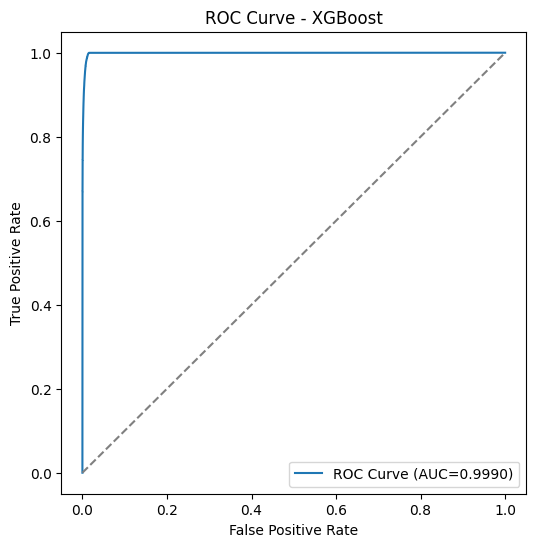

In [9]:
# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test_binary, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

In [10]:
# --- Save test predictions and probabilities for ensemble ---
pd.DataFrame({
    "y_test_binary": y_test_binary,
    "y_pred": y_pred,
    "y_proba": y_proba
}).to_pickle(DATA_DIR / "xgb_test_results_vf.pkl")